In [1]:
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.message import add_messages # A reducer function
from langchain_openai import ChatOpenAI, AzureChatOpenAI
from pydantic import BaseModel
from dotenv import load_dotenv
from typing import Annotated
from databricks_langchain import ChatDatabricks
import os
from client import AzureAIClient
from IPython.display import Image, display
import gradio as gr
import requests
from langchain.agents import Tool
from utils import send_email
from langchain_community.utilities import GoogleSerperAPIWrapper
from langgraph.checkpoint.memory import MemorySaver
from pydantic import BaseModel
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver


c:\Users\edan\repos\personal_projects\AI\Agentic_AI_Projects\langgraph_sidekick\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv(override=True)

True

In [3]:
# Create a simple state
class State(BaseModel):
    messages: Annotated[list, add_messages]

In [4]:
# Get llms
llm_db = ChatDatabricks(endpoint="databricks-claude-3-7-sonnet", max_tokens=1000)

llm_az = AzureChatOpenAI(
    api_version="2024-12-01-preview",
    azure_ad_token_provider=AzureAIClient().token_provider,
    azure_deployment="gpt-4o"
    # azure_deployment="o4-mini"
)

2025-07-06 02:24:18.710 | SUCCESS  | client:_get_token_provider:41 - Successfully initialized Azure Credentials!!


### Simple chatbot graph for practice

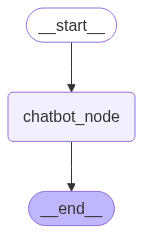

In [5]:
# Build a graph
graph_builder = StateGraph(state_schema=State)

# Create node
def chatbot_node(old_state: State) -> State:
    response = llm_az.invoke(old_state.messages)
    new_state = State(messages=[response])
    return new_state

graph_builder.add_node("chatbot_node", chatbot_node)

# Create Edges
graph_builder.add_edge(START, "chatbot_node")
graph_builder.add_edge("chatbot_node", END)

# Create the graph
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
# Create a simple chat interface using gradio
def chat(user_input: str, history):
    initial_state = State(messages=[{"role": "user", "content": user_input}])
    result = graph.invoke(initial_state)
    print(result)
    return result["messages"][-1].content

gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='hi there', additional_kwargs={}, response_metadata={}, id='f4febdcb-ec4c-4753-92fd-34c8f56680c5'), AIMessage(content='Hello! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 8, 'total_tokens': 36, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'o4-mini-2025-04-16', 'system_fingerprint': None, 'id': 'chatcmpl-BpyenCKVJAf7iU9PDq0OggT66lzJQ', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}]

## Making a more functional langgraph agentic workflow

In [5]:
# Get a nice googler serper fucntion
serper = GoogleSerperAPIWrapper()
# serper.run("What is the current date?")

In [6]:
# Create a new tool for the agent
tool_search = Tool(
    name="google_search",
    func=serper.run,
    description="Useful for when you need more information from an online search"
)

In [ ]:
# tool_search.run("Who is the current president of India?")

'Droupadi Murmu'

In [7]:
pushover_token = os.getenv("PUSHOVER_TOKEN")
pushover_user = os.getenv("PUSHOVER_USER")
pushover_url = "https://api.pushover.net/1/messages.json"

def push(text: str):
    """Send a push notification to the user"""
    requests.post(pushover_url, data = {"token": pushover_token, "user": pushover_user, "message": text})

In [8]:
tool_push = Tool(
    name="push_notification",
    func=push,
    description="Useful for sending push notifications to the user"
)
# tool_push.invoke("Hi there this is from pushover!")

In [9]:
# Another tool for sending emails
tool_email = Tool(
    name="send_email",
    func=send_email,
    description="Useful for sending emails to the user"
)

In [10]:
tools = [tool_search, tool_push, tool_email]
# tools = [tool_search, tool_email]
llm_az_tools = llm_az.bind_tools(tools)

In [11]:
graph_builder2 = StateGraph(state_schema=State)

# Nodes again
def chatbot_node(old_state: State) -> State:
    response = llm_az_tools.invoke(old_state.messages)
    new_state = State(messages=[response])
    return new_state

graph_builder2.add_node("chatbot_node", chatbot_node)
graph_builder2.add_node("tools", ToolNode(tools=tools))

# Add edges with conditions
graph_builder2.add_conditional_edges("chatbot_node", tools_condition, "tools")
graph_builder2.add_edge("tools", "chatbot_node")

graph_builder2.add_edge(START, "chatbot_node")


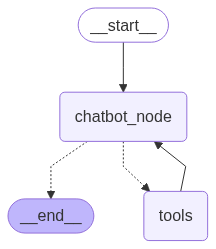

In [ ]:
# Compile the graph
# Adding state management with memory
memory = MemorySaver()

graph2 = graph_builder2.compile(checkpointer=memory)
display(Image(graph2.get_graph().draw_mermaid_png()))

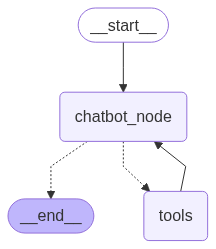

In [12]:
# For persisting state memory
db_path="sqlite_memory.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

sql_memory = SqliteSaver(conn)

# graph2 = graph_builder2.compile(checkpointer=memory)
graph2 = graph_builder2.compile(checkpointer=sql_memory)
display(Image(graph2.get_graph().draw_mermaid_png()))

In [13]:
# Adding memory based on the thread used
config = {"configurable": {"thread_id": "1"}}

# Create a simple chat interface using gradio
def invoke_graph(user_input: str, history):
    initial_state = State(messages=[{"role": "user", "content": user_input}])
    result = graph2.invoke(initial_state, config=config)
    print(result)
    return result["messages"][-1].content

gr.ChatInterface(invoke_graph, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='Hi my name is Ilyan', additional_kwargs={}, response_metadata={}, id='bbc61662-ff48-481e-b255-91a51267c0b0'), AIMessage(content='Hello Ilyan! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 122, 'total_tokens': 136, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-Bq5Z6m237ogAx5Q3UDNttzncPHCVN', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered

In [14]:
list(graph2.get_state(config))

[{'messages': [HumanMessage(content='Hi my name is Ilyan', additional_kwargs={}, response_metadata={}, id='bbc61662-ff48-481e-b255-91a51267c0b0'),
   AIMessage(content='Hello Ilyan! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 122, 'total_tokens': 136, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-Bq5Z6m237ogAx5Q3UDNttzncPHCVN', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filt

In [15]:
# You can also see the state history
list(graph2.get_state_history(config))

[StateSnapshot(values={'messages': [HumanMessage(content='Hi my name is Ilyan', additional_kwargs={}, response_metadata={}, id='bbc61662-ff48-481e-b255-91a51267c0b0'), AIMessage(content='Hello Ilyan! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 122, 'total_tokens': 136, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-Bq5Z6m237ogAx5Q3UDNttzncPHCVN', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 